In [13]:
import pandas as pd
import numpy as np
df_bandarban = pd.read_csv('../1980-2024-dataset/Chittagong_historical_weather_1980_2024.csv')
df_bandarban = df_bandarban.drop('district', axis =1 )

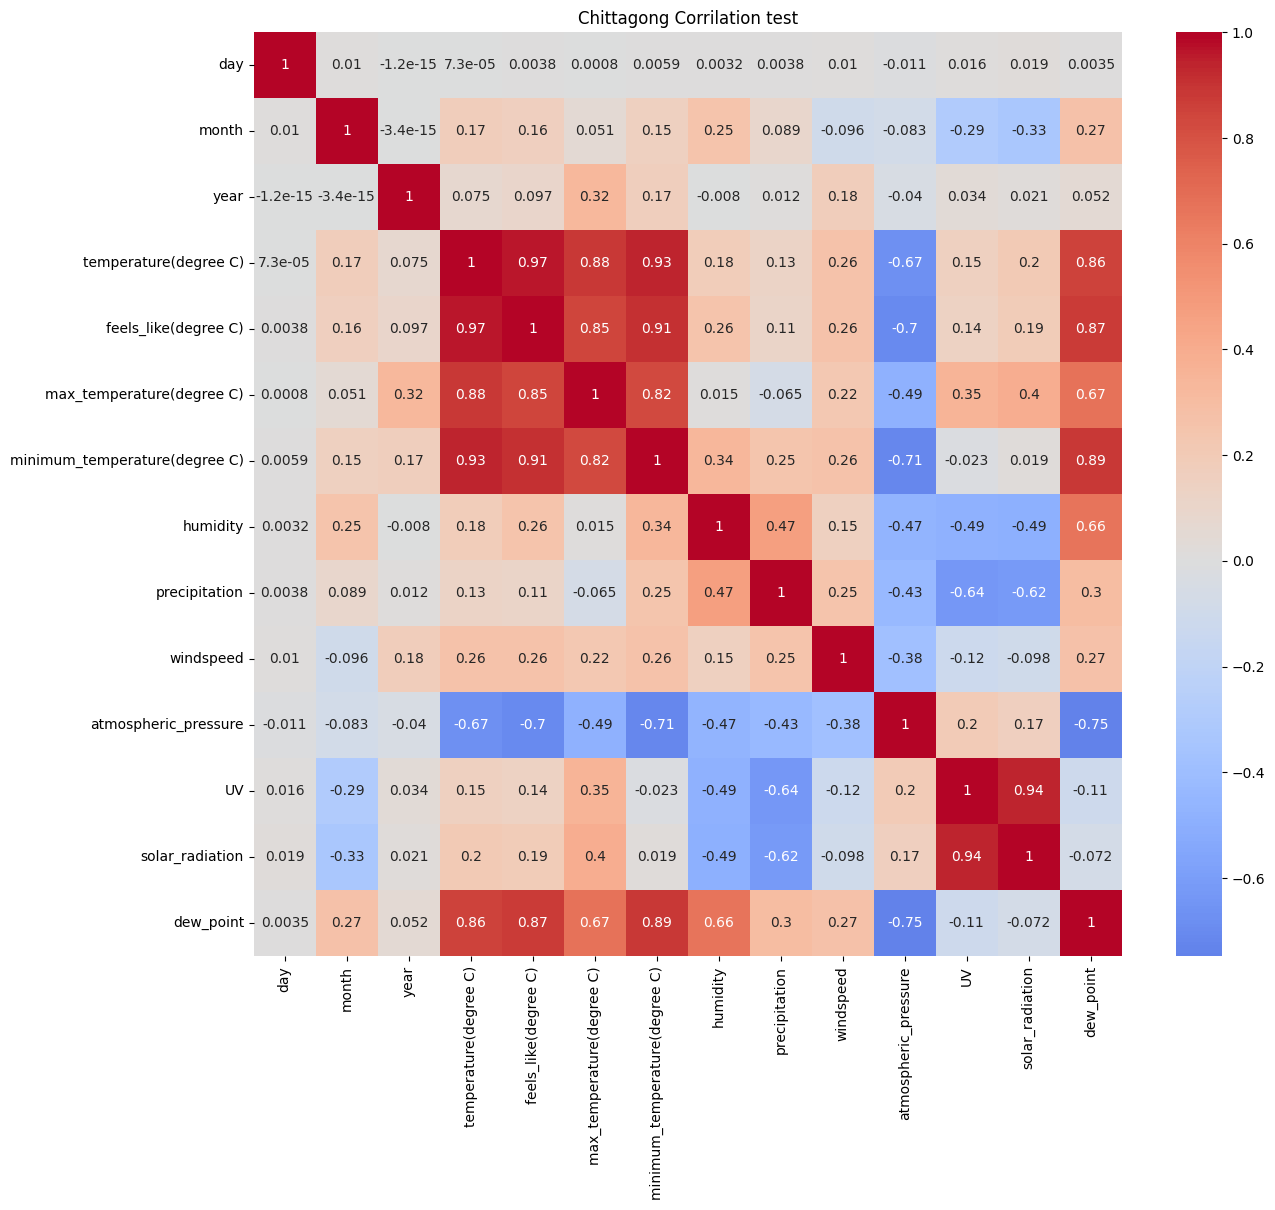

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a correlation matrix
corr_matrix = df_bandarban.corr()

# Plot the correlation matrix
plt.figure(figsize=(14, 12))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Chittagong Corrilation test')
plt.show()

In [15]:
df_bandarban.head()

,day,month,year,temperature(degree C),feels_like(degree C),max_temperature(degree C),minimum_temperature(degree C),humidity,precipitation,windspeed,atmospheric_pressure,UV,solar_radiation,dew_point
0,1,1,1980,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,1,1980,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,1,1980,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,1,1980,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,1,1980,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# DEW POINT

In [44]:
import pandas as pd
import numpy as np
df_bandarban = pd.read_csv('../1980-2024-dataset/bandarban_historical_weather_1980_2024.csv')
df_bandarban = df_bandarban.drop('district', axis =1 )

from sklearn.model_selection import train_test_split
import numpy as np

df = df_bandarban.copy()
if 'date' not in df.columns:
    df['date'] = pd.to_datetime(df[['year', 'month', 'day']])


# 'atmospheric_pressure','humidity', 'minimum_temperature(degree C)' [collected based on the corrilation matrix]

# adding lagging for 3 days
lags = [1, 2, 3]
lag_cols = []

for lag in lags:
    df[f'atm_lag_{lag}'] = df['atmospheric_pressure'].shift(lag)
    df[f'hum_lag_{lag}'] = df['humidity'].shift(lag)
    df[f'mintem_lag_{lag}'] = df['minimum_temperature(degree C)'].shift(lag)
    # df[f'UV_lag_{lag}'] = df['UV'].shift(lag)
    # df[f'ppt_lag_{lag}'] = df['precipitation'].shift(lag)
    
    lag_cols.extend([f'atm_lag_{lag}', f'hum_lag_{lag}', f'mintem_lag_{lag}'])


# 7-day Rolling Average
df['atm_roll_7'] = df['atmospheric_pressure'].transform(lambda x: x.rolling(window=7).mean())
df['dew_roll_7'] = df['humidity'].transform(lambda x: x.rolling(window=7).mean())
df['mintem_roll_7'] = df['minimum_temperature(degree C)'].transform(lambda x: x.rolling(window =7).mean())


rolling_cols = ['atm_roll_7', 'dew_roll_7', 'mintem_roll_7']


df = df.dropna().reset_index(drop=True)


df['date'] = pd.to_datetime(df[['year', 'month', 'day']])
df = df.sort_values('date').reset_index(drop=True)

df['day_of_year'] = df['date'].dt.dayofyear

def add_fourier_features(df,col,period,n_terms=10):
    for n in range(1, n_terms + 1):
        df[f'{col}_sin_{n}'] = np.sin(2 * np.pi * n * df.index / period)
        df[f'{col}_cos_{n}'] = np.cos(2 * np.pi * n * df.index / period)
    return df

df = add_fourier_features(df, 'day_of_year', period=365, n_terms=3)
fourier_cols = [c for c in df.columns if c.startswith('day_of_year_sin') or c.startswith('day_of_year_cos')]


In [49]:
FEATURES = [
    'minimum_temperature(degree C)',
    'mintem_roll_7',
    'mintem_lag_1',
    'mintem_lag_2',
    'mintem_lag_3',
    'atm_roll_7',
    'atm_lag_2',
    'atmospheric_pressure',
    'day_of_year_cos_1',
    'atm_lag_3',
    'atm_lag_1',
    'humidity', # 93.44/94.73 *-1.28
    'day_of_year_sin_3', # 93.38/94.71 *-1.32
    'day_of_year_sin_1', # 93.20/94.49 *-1.29
    'dew_roll_7',
    'hum_lag_1', # 93.75/94.87 *-0.096 [best]
    # 'day_of_year_sin_2', 
]

# FEATURES = [ 'atmospheric_pressure','humidity', 'minimum_temperature(degree C)'] + fourier_cols + lag_cols + rolling_cols # (first e eita uncomment kore feature importance dekhben. then 0.02 minmum importance gula note down kore prediction korben)
# 93.05/94.29 *-1.24

X = df[FEATURES]
y = df['dew_point']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

In [50]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
from sklearn.model_selection import KFold
from sklearn.model_selection import TimeSeriesSplit

'''
Random Forest Feature Importances (from last fold):
                          Feature  Importance
2   minimum_temperature(degree C)    0.216909
20                  mintem_roll_7    0.146150
11                   mintem_lag_1    0.131497
14                   mintem_lag_2    0.122413
17                   mintem_lag_3    0.073617
18                     atm_roll_7    0.056844
12                      atm_lag_2    0.039081
0            atmospheric_pressure    0.035956
4               day_of_year_cos_1    0.025367
15                      atm_lag_3    0.025037
9                       atm_lag_1    0.024415
1                        humidity    0.024317
7               day_of_year_sin_3    0.019913
3               day_of_year_sin_1    0.010451
19                     dew_roll_7    0.009862
10                      hum_lag_1    0.009594
5               day_of_year_sin_2    0.008322
6               day_of_year_cos_2    0.007584
13                      hum_lag_2    0.005335
16                      hum_lag_3    0.004013
8               day_of_year_cos_3    0.003323


'''


rf_model = {}
y_preds_rf = {}
rmses_rf = {} # eigula active korte hobe
r2s_rf = {}


rf_model = RandomForestRegressor(
        n_estimators= 800 ,
        random_state=42,
        max_depth=22,
        min_samples_split=2,
        min_samples_leaf=1,
        n_jobs=-1,
        max_features='sqrt'
    )
rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)


    # model evaluation
mse_rf = mean_squared_error(y_test, y_pred)
rmse_rf = np.sqrt(mse_rf)
r2_rf = r2_score(y_test, y_pred)

print(f"\nRandom Forest Results for dewpoint:")
print(f'MSE: {mse_rf:.4f}')
print(f'RMSE: {rmse_rf:.4f}')
print(f'R² Score: {r2_rf:.4f}')

    # k fold cross-validation 
    # 1. Initialize TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

rmse_list_rf = []
r2_list_rf = [] # Added to track R2 across all folds
mse_list_rf = []

for train_index, test_index in tscv.split(X):
    # iloc is used to split by integer position
    X_train_kf, X_test_kf = X.iloc[train_index], X.iloc[test_index]
    
    # FIX: y is already a Series, just use iloc[index] 
    y_train_kf = y.iloc[train_index]
    y_test_kf = y.iloc[test_index]
    
    rf_model_kf = RandomForestRegressor(
        n_estimators=800,
        random_state=42,
        max_depth=22,
        min_samples_split=2,
        min_samples_leaf=1,
        n_jobs=-1,
        max_features='sqrt'
    )

    # Training
    rf_model_kf.fit(X_train_kf, y_train_kf)
    y_pred_kf_rf = rf_model_kf.predict(X_test_kf)

    # Metrics
    mse_kf_rf = mean_squared_error(y_test_kf, y_pred_kf_rf)
    rmse_kf_rf = np.sqrt(mse_kf_rf)
    r2_kf_rf = r2_score(y_test_kf, y_pred_kf_rf)
    
    rmse_list_rf.append(rmse_kf_rf)
    r2_list_rf.append(r2_kf_rf)
    mse_list_rf.append(mse_kf_rf)

# Final Aggregates
average_rmse_rf = np.mean(rmse_list_rf)
average_r2_rf = np.mean(r2_list_rf)
average_mse_rf = np.mean(mse_list_rf)

print(f"Average RMSE from CV: {average_rmse_rf:.4f}")
print(f"Average R² from CV: {average_r2_rf:.4f}")
print(f"Avarage MSE: {average_mse_rf}")
print(f"Individual Fold RMSEs: {rmse_list_rf}")

# Feature importance - Using the model from the LAST fold
importance = rf_model_kf.feature_importances_
feature_names = X.columns
feature_importance_df_rf = pd.DataFrame({'Feature': feature_names, 'Importance': importance})
feature_importance_df_rf = feature_importance_df_rf.sort_values(by='Importance', ascending=False)

diff = (r2_rf - average_r2_rf)*100
print ( f'\n R2 ~ {diff:.4f}')
print("\nRandom Forest Feature Importances (from last fold):")
print(feature_importance_df_rf)




Random Forest Results for dewpoint:
MSE: 0.7963
RMSE: 0.8924
R² Score: 0.9633
Average RMSE from CV: 0.8521
Average R² from CV: 0.9642
Avarage MSE: 0.7304226809592761
Individual Fold RMSEs: [np.float64(0.9223201469132752), np.float64(0.8293547686530703), np.float64(0.9003761336604036), np.float64(0.7349241156673033), np.float64(0.8733950888641645)]

 R2 ~ -0.0958

Random Forest Feature Importances (from last fold):
                          Feature  Importance
0   minimum_temperature(degree C)    0.271843
1                   mintem_roll_7    0.192041
2                    mintem_lag_1    0.144880
3                    mintem_lag_2    0.091773
4                    mintem_lag_3    0.079718
5                      atm_roll_7    0.054594
11                       humidity    0.045451
6                       atm_lag_2    0.024515
10                      atm_lag_1    0.020727
9                       atm_lag_3    0.016322
7            atmospheric_pressure    0.015675
15                      hum_l

# RF-LSTM hybrid

In [41]:
FEATURES = [
    'minimum_temperature(degree C)',
    'mintem_roll_7',
    'mintem_lag_1',
    'mintem_lag_2',
    'mintem_lag_3',
    'atm_roll_7',
    'atm_lag_2',
    'atmospheric_pressure',
    'day_of_year_cos_1',
    'atm_lag_3',
    'atm_lag_1',
    'humidity', # 93.44/94.73 *-1.28
    'day_of_year_sin_3', # 93.38/94.71 *-1.32
    'day_of_year_sin_1', # 93.20/94.49 *-1.29
    'dew_roll_7',
    'hum_lag_1', # 93.75/94.87 *-1.12 [best]
    # 'day_of_year_sin_2', #
]

# FEATURES = [ 'atmospheric_pressure','humidity', 'minimum_temperature(degree C)'] + fourier_cols + lag_cols + rolling_cols # (first e eita uncomment kore feature importance dekhben. then 0.02 minmum importance gula note down kore prediction korben)
# 93.05/94.29 *-1.24

X = df[FEATURES]
y = df['temperature(degree C)']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

In [42]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Input
from sklearn.metrics import mean_squared_error, r2_score
from keras.optimizers import Adam, SGD

def create_sequences(x_data, y_data, window_size=5):
    X_seq, y_seq = [], []
    for i in range(window_size, len(x_data)):
        X_seq.append(x_data[i-window_size:i]) # Grab the previous 'n' days
        y_seq.append(y_data[i])               # The error of the CURRENT day
    return np.array(X_seq), np.array(y_seq)

# 1. Chronological Split (No Shuffling!)
train_size = int(len(df) * 0.8)

# These keep their column names (Good for RF)
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

# 2. Re-fit your RF models on X_train explicitly to ensure they "own" the names
rf_model.fit(X_train, y_train)


# Get predictions on the training set using the DataFrames
train_preds_temp = rf_model.predict(X_train)


# Calculate Residuals (Errors)
res_temp = y_train.values - train_preds_temp


# Combine into a single error target for the LSTM
train_residuals = np.column_stack([res_temp])

# 1. Scale the features for the LSTM
scaler_x = StandardScaler()
X_train_scaled = scaler_x.fit_transform(X_train)
X_test_scaled = scaler_x.transform(X_test)



# --- NEW SLIDING WINDOW BLOCK ---
window_size = 5  # You can try 3, 5, or 7

# Create sequences for training
X_train_lstm, train_residuals_seq = create_sequences(X_train_scaled, train_residuals, window_size)

# Create sequences for testing
X_test_lstm, _ = create_sequences(X_test_scaled, np.zeros((len(X_test_scaled), 3)), window_size)

# Update the LSTM Input Shape
lstm_model = Sequential([
    Input(shape=(window_size, X_train_lstm.shape[2])), # Updated: shape is now (5, features)
    LSTM(32, activation='tanh'), 
    Dense(16, activation='relu'),
    Dense(3) 
])
# Note: Use train_residuals_seq here instead of train_residuals
lstm_model.compile(optimizer='adam', loss='mae')
lstm_model.fit(X_train_lstm, train_residuals_seq, epochs=40, batch_size=32, verbose=0)

# --- UPDATED PREDICTION BLOCK ---
# We skip the first 'window_size' rows of X_test to match the LSTM output
X_test_aligned = X_test.iloc[window_size:]
y_test_aligned = y_test.iloc[window_size:]

# Get RF predictions on the ALIGNED test set
rf_t_pred = rf_model.predict(X_test_aligned)

# Get LSTM corrections (These will already be aligned because of create_sequences)
corrections = lstm_model.predict(X_test_lstm)

# Combine
final_temp = rf_t_pred + corrections[:, 0]


print(f"Windowed UV R2: {r2_score(y_test_aligned, final_temp):.4f}")
print(f"Windowed UV MSE: {mean_squared_error(y_test_aligned, final_temp):.4f}")
print(f"Windowed UV RMSE: {np.sqrt(mean_squared_error(y_test_aligned, final_temp)):.4f}")



26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Windowed UV R2: 0.9389
Windowed UV MSE: 0.7572
Windowed UV RMSE: 0.8702


In [43]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Input
from sklearn.metrics import mean_squared_error, r2_score
from keras.optimizers import Adam, SGD

# --- STEP 1: Selective Features for LSTM ---
# We only give the LSTM the most important "weather" features to reduce noise
lstm_feature_cols = [
    'minimum_temperature(degree C)',
    'mintem_roll_7',
    'mintem_lag_1',
    'mintem_lag_2',
    'mintem_lag_3',
    'atm_roll_7',
    'atm_lag_2',
    'atmospheric_pressure',
    'day_of_year_cos_1',
    'atm_lag_3',
    'atm_lag_1',
    'humidity', # 93.44/94.73 *-1.28
    'day_of_year_sin_3', # 93.38/94.71 *-1.32
    'day_of_year_sin_1', # 93.20/94.49 *-1.29
    'dew_roll_7',
    'hum_lag_1', # 93.75/94.87 *-1.12 [best]
]
X_train_slim = X_train[lstm_feature_cols]
X_test_slim = X_test[lstm_feature_cols]

scaler_slim = StandardScaler()
X_train_scaled = scaler_slim.fit_transform(X_train_slim)
X_test_scaled = scaler_slim.transform(X_test_slim)

# --- STEP 2: Create Sequences ---
window_size = 7 # Try a full week
X_train_seq, y_train_res_seq = create_sequences(X_train_scaled, train_residuals, window_size)
X_test_seq, _ = create_sequences(X_test_scaled, np.zeros((len(X_test_scaled), 2)), window_size)

# --- STEP 3: Optimized LSTM ---
lstm_model = Sequential([
    Input(shape=(window_size, X_train_scaled.shape[1])),
    LSTM(100, activation='tanh', return_sequences=True), # Return sequences for deeper learning
    LSTM(50, activation='tanh'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(2) 
])

# Use a slightly slower learning rate to find the pattern

lstm_model.compile(optimizer=Adam(learning_rate=0.001), loss='huber') # Huber loss is great for weather outliers
lstm_model.fit(X_train_seq, y_train_res_seq, epochs=60, batch_size=64, verbose=0)

# 1. Align the Test Data (Skip the first 7 days used for the window)
X_test_aligned = X_test.iloc[window_size:]
y_test_aligned = y_test.iloc[window_size:]

# 2. Get the "Base" predictions from your Random Forest
rf_t_pred = rf_model.predict(X_test_aligned)

# 3. Get the "Corrections" from the LSTM
# X_test_seq was created during your sequence step
lstm_corrections = lstm_model.predict(X_test_seq)

# 4. Combine them: Base + Correction
final_uv = rf_t_pred + lstm_corrections[:, 0]

rf_lstm_r2 = r2_score(y_test_aligned, final_uv)
rf_lstm_mse = mean_squared_error(y_test_aligned, final_uv)
rf_lstm_rmse = np.sqrt(rf_lstm_mse)

# 5. Output the New Results
print("--- HYBRID MODEL PERFORMANCE ---")
print(f"Final temperature R2: {rf_lstm_r2:.4f}")
print(f"Final temperature MSE: {rf_lstm_mse:.4f}")
print(f"Final temperature RMSE: {rf_lstm_mse:.4f}")
# final r2 90.90/89.87 

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
--- HYBRID MODEL PERFORMANCE ---
Final temperature R2: 0.9384
Final temperature MSE: 0.7640
Final temperature RMSE: 0.7640


In [ ]:
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt



# 1. Initialize TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

# Assuming X and y are your full datasets before the train/test split
# X_full, y_full, rf_model, create_sequences need to be defined in your workspace

DEW = 'dew_point'
X_full = df[FEATURES]
y_full = df[TEMP]

fold = 1
lstmRf_hybrid_r2_scores = []
lstmRf_hybrid_mse_scores = []
lstmRf_hybrid_rmse_scores = []

for train_index, test_index in tscv.split(X_full):

    print(f"--- Processing Fold {fold} ---")
    
    # Split Data
    X_train_cv, X_test_cv = X_full.iloc[train_index], X_full.iloc[test_index]
    y_train_cv, y_test_cv = y_full.iloc[train_index], y_full.iloc[test_index]
    
    # --- STEP 1: Random Forest Base Model (Required for Residuals) ---

    # Training the RF on the current fold's training set
    rf_model.fit(X_train_cv, y_train_cv)
    train_residuals = y_train_cv - rf_model.predict(X_train_cv)
    
    # --- STEP 2: Preprocessing for LSTM ---
    lstm_feature_cols = [
        'minimum_temperature(degree C)',
    'temp_lag_1',
    'temp_roll_7', # 
    'temp_lag_2', # 
    'temp_lag_3', # 
    'atm_roll_7', # 
    'atm_lag_2', # ~ 1.84 r2
    'atmospheric_pressure', # r2 -> ~ 1.15
    'atm_lag_1', # 89.78/90.78 ~ -1
    'day_of_year_sin_3', # 90.84/91.71 ~ -0.86
    'atm_lag_3', # 90.79/91.60 ~-0.80 [better]
    ]

    scaler = StandardScaler().set_output(transform="pandas")

    X_train_scaled = scaler.fit_transform(X_train_cv[lstm_feature_cols])
    X_test_scaled = scaler.transform(X_test_cv[lstm_feature_cols])
    
    # --- STEP 3: Create Sequences ---
    window_size = 5
    X_train_seq, y_train_res_seq = create_sequences(X_train_scaled, train_residuals.values, window_size)
    # We pass zeros for y_test as we only need the X sequences for prediction
    X_test_seq, _ = create_sequences(X_test_scaled, np.zeros((len(X_test_scaled), 2)), window_size)
    
    # --- STEP 4: Train LSTM ---
    # Re-initialize the model each fold to avoid weight leakage
    lstm_model = Sequential([
        Input(shape=(window_size, X_train_scaled.shape[1])),
        LSTM(100, activation='tanh', return_sequences=True),
        LSTM(50, activation='tanh'),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dense(1) 
    ])
    
    lstm_model.compile(optimizer=Adam(learning_rate=0.001), loss='huber')
    lstm_model.fit(X_train_seq, y_train_res_seq, epochs=30, batch_size=64, verbose=0)
    
    # --- STEP 5: Hybrid Prediction & Evaluation ---
    # Align target data (drop first 'window_size' rows)
    y_test_aligned = y_test_cv.iloc[window_size:]
    rf_base_pred = rf_model.predict(X_test_cv.iloc[window_size:])
    
    lstm_corrections = lstm_model.predict(X_test_seq)
    lstmRf_hybrid_prediction = rf_base_pred + lstm_corrections[:, 0] # Adjust index if target is multi-output
    
    # Calculate Metrics
    lstmRf_hybrid_r2_kf = r2_score(y_test_aligned, lstmRf_hybrid_prediction)
    lstmRf_hybrid_mse_kf = mean_squared_error(y_test_aligned, lstmRf_hybrid_prediction)
    lstmRf_hybrid_rmse_kf = np.sqrt(lstmRf_hybrid_mse_kf)

    lstmRf_hybrid_r2_scores.append(lstmRf_hybrid_r2_kf)
    lstmRf_hybrid_mse_scores.append(lstmRf_hybrid_mse_kf)
    lstmRf_hybrid_rmse_scores.append(lstmRf_hybrid_rmse_kf)

    print(f"Fold {fold} R2: {lstmRf_hybrid_r2_kf:.4f}")
    print(f"Fold {fold} MSE: {lstmRf_hybrid_mse_kf:.4f}")
    print(f"Fold {fold} RMSE: {lstmRf_hybrid_rmse_kf:.4f}")
    fold += 1

rf_lstm_r2_cv = np.mean(lstmRf_hybrid_r2_scores)
rf_lstm_mse_cv = np.mean(lstmRf_hybrid_mse_scores)
rf_lstm_rmse_cv = np.mean(lstmRf_hybrid_rmse_scores)

print("\n--- FINAL CROSS-VALIDATION RESULTS ---")
print(f"Mean R2: {rf_lstm_r2_cv:.4f} (+/- {np.std(lstmRf_hybrid_r2_scores):.4f})")
print(f"Mean mse: {rf_lstm_mse_cv:.4f} (+/- {np.std(lstmRf_hybrid_mse_scores):.4f})")
print(f"Mean rmse: {rf_lstm_rmse_cv:.4f} (+/- {np.std(lstmRf_hybrid_rmse_scores):.4f})")

